In [1]:
import numpy as np

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils
import LearningCutsUtils.Utils as LCU
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.Utils)

<module 'LearningCutsUtils.Utils' from '/home/mhance/NN-For-Cuts/LearningCutsUtils/Utils.py'>

In [3]:
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars

In [4]:
import pandas as pd

In [6]:
x=None
y=None

N=0 # number of points
m=0 # dimensions

if False:
    # array of means and widths for gaussians,
    # indices are:
    # - number of dimensions
    # - signal (0) vs background (1)
    # - mean (0) vs width (1)

    N=20000 # number of points
    m=10 # dimensions
    
    np.random.seed(123)
    width_scale_factor=2.
    mean_scale_factor=1.
    
    # if we want more control over the function, for example
    means_widths=[[[4,0.4],
                   [-2,.10]],
                  [[3,1.0],
                   [-1,0.5]]]
    
    means_widths=np.random.randn(m,2,2)               
    
    # now construct the training data.  after taking transpose, should be N rows by m columns.  
    x_signal=np.array([mean_scale_factor*means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
    y_signal=np.ones(N)
    x_backgr=np.array([mean_scale_factor*means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
    y_backgr=np.zeros(N)
    x=np.concatenate((x_signal,x_backgr))
    y=np.concatenate((y_signal,y_backgr))
else:
    # Prep Data using Pandas
    x_sig_data=None
    y_sig_data=None
    
    x_bkg_data=None
    y_bkg_data=None
    
    num_sig_events=0
    num_bkg_events=0
    
    # Need to copy the last branch, Rll, so that we have a total of 5 branches
    branches=[
        'lep1Pt','lep1Eta','lep1Phi','lep1MT_Met','lep1_DPhiMet',
        'lep2Pt','lep2Eta','lep2Phi','lep2MT_Met','lep2_DPhiMet',
        'met_Et','met_Phi',
        'Rll',
    #    'nJet30','mt2leplsp_100'
    ]
    
    # open signal
    mass=200
    split=30
    filepath='/data/mhance/SUSY/Compressed/'
    filebase='SusySkimSlep_v0.2_SlepSignals__'
    filename='MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_%dp0_%dp0_NoSys' % (mass,mass-split)
    filesuff='.hf5'
    
    # Makes data frame for signal events
    fullname=filepath+filebase+filename+filesuff
    df = pd.read_hdf(fullname, key=filename)
    df1 = df[branches].to_numpy()
    num_sig_events = len(df1)
    x_signal = df1
    y_signal = np.ones(num_sig_events)
    print("Extracted %7d signal events" % num_sig_events)

    # Now background
    fullname=filepath+"SusySkimSlep_v0.2_diboson2L__diboson2L_NoSys"+filesuff
    df = pd.read_hdf(fullname, key='diboson2L_NoSys')
    df2 = df[branches].to_numpy()
    num_bkg_events = len(df2)
    x_backgr = df2
    y_backgr=np.zeros(num_bkg_events)
    print("Extracted %7d background events" % num_bkg_events)    

    
    if num_bkg_events>num_sig_events:
        x = np.concatenate((x_signal,x_backgr[:num_sig_events]))
        y = np.concatenate((y_signal,y_backgr[:num_sig_events]))
        N=2*num_bkg_events
    else:
        x = np.concatenate((x_signal[:num_bkg_events],x_backgr))
        y = np.concatenate((y_signal[:num_bkg_events],y_backgr))
        N=2*num_sig_events
    m=len(branches)

Extracted  251106 signal events
Extracted  126906 background events


In [7]:
print(x_signal.shape)

(251106, 13)


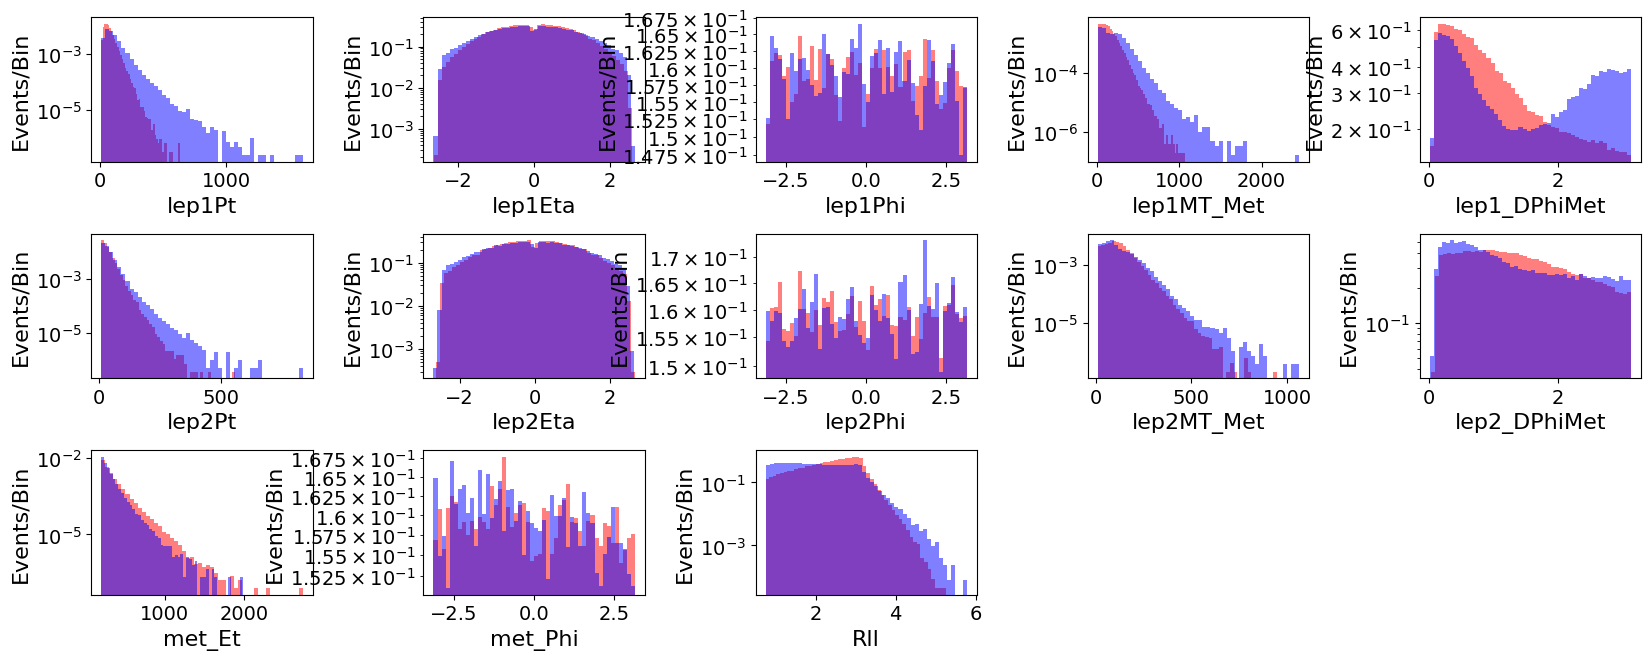

In [8]:
fig = plt.figure(figsize=(20,2.5*(int(m/5)+1)))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(int(m/5)+1,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"{branches[b]}")
    ax.set_ylabel("Events/Bin")
plt.savefig("features_dummy.pdf")

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [10]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [11]:
# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=200

In [12]:
torch.manual_seed(123)

net=None

simplenet=False
if simplenet:
    net = torch.nn.Sequential(
        torch.nn.Linear(m, 1,bias=False),
        torch.nn.Sigmoid()
    )
else:
    net = torch.nn.Sequential(
        torch.nn.Linear(m, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 1),
        torch.nn.Sigmoid()
    )

torch.save(net.state_dict(), 'net_FC_untrained.pth')
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [13]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_FC_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred = net(x_batch).squeeze(1)
        optimizer.zero_grad()
        loss = torch.nn.BCELoss()(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
    losses.append(loss.data)

    # configure the model for evaluation (testing)
    net.eval()
    
    y_pred = net(x_test_tensor).squeeze(1)
    test_loss = torch.nn.BCELoss()(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
                
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

torch.save(net.state_dict(), 'net_FC_trained.pth')

Completed epoch  0 in  4.6s, Train loss=7.0e-01, Test loss=6.7e-01
Completed epoch  1 in  3.9s, Train loss=6.7e-01, Test loss=6.5e-01
Completed epoch  2 in  3.3s, Train loss=6.5e-01, Test loss=6.2e-01
Completed epoch  3 in  4.4s, Train loss=6.2e-01, Test loss=5.8e-01
Completed epoch  4 in  4.1s, Train loss=5.8e-01, Test loss=5.8e-01
Completed epoch  5 in  4.0s, Train loss=5.8e-01, Test loss=5.6e-01
Completed epoch  6 in  3.0s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch  7 in  3.4s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch  8 in  3.7s, Train loss=5.6e-01, Test loss=5.5e-01
Completed epoch  9 in  3.1s, Train loss=5.5e-01, Test loss=5.5e-01
Completed epoch 10 in  3.5s, Train loss=5.5e-01, Test loss=5.4e-01
Completed epoch 11 in  2.9s, Train loss=5.4e-01, Test loss=5.4e-01
Completed epoch 12 in  3.0s, Train loss=5.4e-01, Test loss=5.3e-01
Completed epoch 13 in  3.0s, Train loss=5.3e-01, Test loss=5.3e-01
Completed epoch 14 in  3.4s, Train loss=5.3e-01, Test loss=5.2

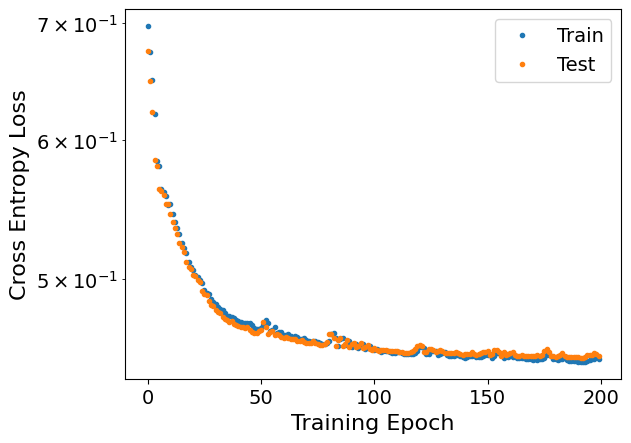

In [14]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

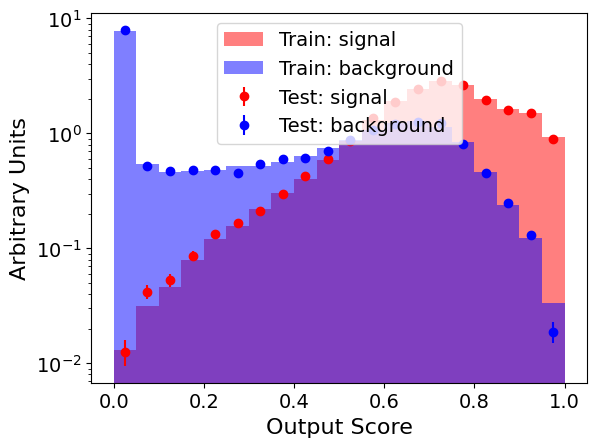

In [15]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = net(x_test_tensor).detach().cpu()
y_pred_train= net(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("scores_FC_dummy.pdf")

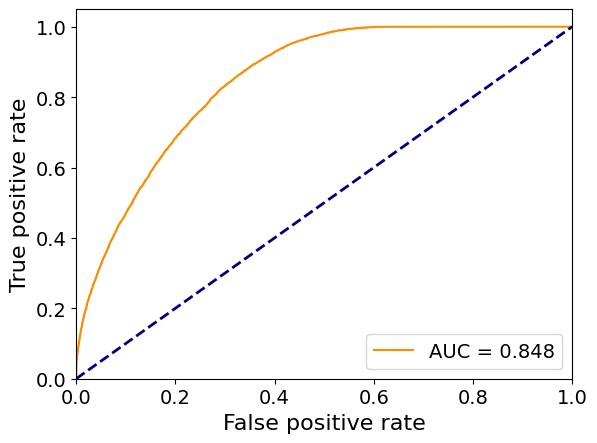

In [16]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("ROC_FC_dummy.pdf")

In [17]:
net[0].weight

Parameter containing:
tensor([[-3.0065e-01, -2.6698e-01, -2.0124e-02,  7.3638e-01, -1.6265e-02,
          5.8377e-01,  4.9199e-01,  3.3356e-02, -5.8935e-01,  9.9815e-02,
          3.4563e-02, -1.5750e-02, -3.2912e-01],
        [-1.0574e+00, -1.6047e-01,  1.0632e-02, -7.2208e-01,  1.5923e-01,
         -1.0114e+00,  1.2585e-01,  2.2291e-02, -5.7177e-01,  3.6625e-01,
          2.1286e-01,  6.7798e-03, -5.4907e-01],
        [ 6.2111e-01, -1.1227e-01, -6.5960e-03, -5.4837e-01,  1.2882e-03,
          2.0647e-01,  1.7726e-01, -3.6963e-02,  6.6879e-02, -3.0340e-01,
         -5.9920e-01,  2.2438e-02, -4.1175e-01],
        [-6.2134e-01, -1.4686e-01,  1.3794e-02, -5.3810e-01, -5.2922e-02,
          1.1113e-02,  1.5382e-01, -2.7789e-02, -4.9011e-01,  3.8657e-02,
          5.1881e-01,  1.8072e-03,  3.3428e-02],
        [ 1.9174e-01,  4.1772e-01,  1.9962e-02,  1.2296e-01,  2.8250e-01,
          9.3301e-01, -3.2173e-01, -7.0995e-02, -7.4247e-02, -7.4046e-01,
          7.9043e-02,  5.5911e-02, -1.5238

In [18]:
net[0].bias

Parameter containing:
tensor([-0.6718, -0.1351, -0.8346,  0.7666, -0.2509,  0.1682, -0.7733, -0.3313,
         0.1588, -0.8901, -0.0868,  0.0549,  0.4018, -0.2405, -0.2900, -0.1620,
        -0.2921,  0.4138, -0.6050,  0.1776], requires_grad=True)

In [19]:
if net[0].bias is not None:
    -net[0].bias/net[0].weight

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net[0].bias.detach().numpy()
    weights=net[0].weight.detach().numpy()
    scaled_cuts=-biases/weights
    
    cuts=sc.inverse_transform(scaled_cuts)[0]
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[0][b] < 0:
            ax.axvline(x = cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = cuts[b], color='y') # cut is "greater than"

RuntimeError: The size of tensor a (20) must match the size of tensor b (13) at non-singleton dimension 1

In [22]:
# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=50

simplenet = torch.nn.Sequential(
    torch.nn.Linear(m, 1, bias=False),
    torch.nn.Sigmoid()
)

torch.save(simplenet.state_dict(), 'net_simpleFC_untrained.pth')
optimizer = torch.optim.SGD(simplenet.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(simplenet.parameters(), lr=0.05)

In [23]:
snlosses = []
snlosses_test = []

simplenet.load_state_dict(torch.load('net_simpleFC_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    simplenet.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred = simplenet(x_batch).squeeze(1)
        optimizer.zero_grad()
        loss = torch.nn.BCELoss()(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
    snlosses.append(loss.data)

    # configure the model for evaluation (testing)
    simplenet.eval()
    
    y_pred = simplenet(x_test_tensor).squeeze(1)
    test_loss = torch.nn.BCELoss()(y_pred, y_test_tensor)
    snlosses_test.append(test_loss.data)
                
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

torch.save(simplenet.state_dict(), 'net_simpleFC_trained.pth')

Completed epoch  0 in  3.2s, Train loss=6.8e-01, Test loss=6.6e-01
Completed epoch  1 in  2.7s, Train loss=6.6e-01, Test loss=6.4e-01
Completed epoch  2 in  2.1s, Train loss=6.4e-01, Test loss=6.3e-01
Completed epoch  3 in  3.1s, Train loss=6.3e-01, Test loss=6.2e-01
Completed epoch  4 in  2.6s, Train loss=6.2e-01, Test loss=6.1e-01
Completed epoch  5 in  2.7s, Train loss=6.1e-01, Test loss=6.1e-01
Completed epoch  6 in  2.6s, Train loss=6.1e-01, Test loss=6.1e-01
Completed epoch  7 in  2.6s, Train loss=6.1e-01, Test loss=6.0e-01
Completed epoch  8 in  3.3s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch  9 in  2.3s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch 10 in  3.2s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch 11 in  2.6s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch 12 in  2.9s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch 13 in  2.9s, Train loss=6.0e-01, Test loss=5.9e-01
Completed epoch 14 in  2.8s, Train loss=5.9e-01, Test loss=5.9

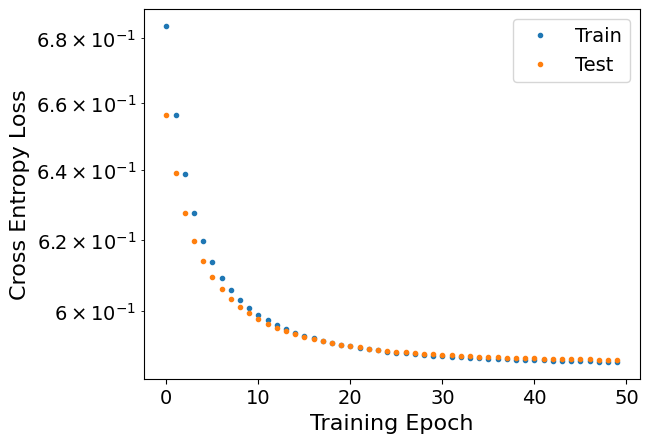

In [24]:
plt.plot(snlosses, '.', label="Train")
plt.plot(snlosses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

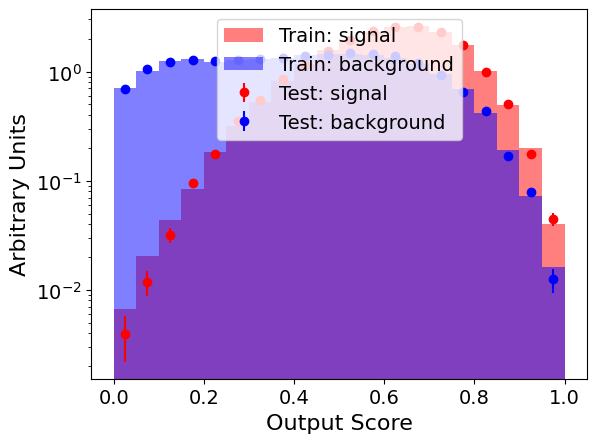

In [25]:
simplenet.eval() # configure the model for evaluation (testing)
y_pred_test = simplenet(x_test_tensor).detach().cpu()
y_pred_train= simplenet(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("scores_simpleFC_dummy.pdf")

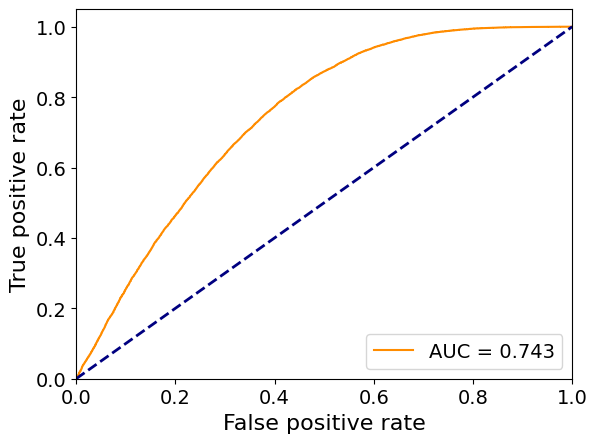

In [26]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("ROC_simpleFC_dummy.pdf")